<a href="https://colab.research.google.com/github/tmor8832/JHub-Python/blob/master/Tweepy_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This code will use the twitter API to collect tweets from a certain area, about a certain term
#It will get the most common words, run through sentiment analysis, plot the tweets on a map
#It will also run basic sentiment analysis on the tweets to determine if they are generally positive or negative

In [2]:
# Install Geopandas, this is used for the map for plotting the tweets
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-tndkw7ce
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-tndkw7ce
     |████████████████████████████████| 15.4 MB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 52.6 MB/s 
  Created wheel for geopandas: filename=geopandas-0.10.2+12.g4361c30-py2.py3-none-any.whl size=1031759 sha256=b055c0133a7c374cae82da950b0aa853115fbe16f97be4d40ec0fc40976e6f96
  Stored in directory: /tmp/pip-ephem-wheel-cache-wpy1lw83/wheels/cf/3e/0b/6475054094c2b1ea054158ac1fdcf749fb92f5b512377e4cf8
Successfully built geopandas


In [3]:
#import the relevant libraries
# guidance for geopandas in this video https://www.youtube.com/watch?v=5G-1k4CNChI
import tweepy #used to access twitter API
from textblob import TextBlob #used for common NLP tasks and analysis
from wordcloud import WordCloud #for generating a wordcloud image
import pandas as pd #used for creating dataframes
import numpy as np #arrays etc
import seaborn as sns #graphical library
import itertools #for iterations and loops
import collections #container datatypes
import re #regular expressions for parsing and NLP
import matplotlib #plotting library
import matplotlib.pyplot as plt
import geopandas as gpd 
import plotly.express as px

In [4]:
#import the API credentials file
from google.colab import files
files.upload()

Saving login.csv to login.csv


{'login.csv': b"key\r\ne1skulGTffD4riROKn5n5RFUk\r\njdeWlPuH49YR1MZLP4mhWDSO29sKbubz3UGKnoDZs0hX6pamU4\r\n1280139097068183552-hIOsTeLEU9iX6iXqI1EWLvrhjCgpIW'\r\n1280139097068183552-hIOsTeLEU9iX6iXqI1EWLvrhjCgpIW\r\nln0YCbQgntyEx41eqfh20v2n5a5KsIu4cFVgeBsgRBQi1"}

In [5]:
#Extract the data from the CSV file and store as variables
log = pd.read_csv('login.csv')
ConsumerKey = log['key'][0]
ConsumerKeySecret = log['key'][1]
AccessToken = log['key'][3]
AccessTokenSecret = log['key'][4]

In [6]:
#Create the authentication object
authenticate = tweepy.OAuthHandler(ConsumerKey, ConsumerKeySecret)
authenticate.set_access_token(AccessToken, AccessTokenSecret)
api = tweepy.API(authenticate)

#Now search twitter for tweets based on key words and location

search_words = "#coronavirus OR #covid19 OR #lockdown"
tweets = tweepy.Cursor(api.search, q = search_words, lang ='en', geocode='51.507218,-0.127586,100km').items(300)
tweet_coordinates = tweepy.Cursor(api.search, q = search_words, lang ='en', geocode='51.507218,-0.127586,1000km').items(300) #make sure there are no spaces between the long and lat and take geocode from
#https://developers.google.com/maps/documentation/geocoding/overview#place-id

#store the tweet text in a variable and then create a dataframe
all_tweets = [tweet.text for tweet in tweets]
combined_information = {'Tweets': all_tweets }
df = pd.DataFrame(combined_information)

#create lat and long variables to store the coordinate data in
latitude= []
longitude = []
#for loop to get coordinate data from the tweets and appends to the variables above
for tweet in tweet_coordinates:
  if str(tweet.coordinates) != 'None':
    s = str(tweet.coordinates) 
    print(tweet.coordinates)
    result = s[s.find('[')+1:s.find(']')]
    print(result)
    lat, lng = result.split(',')
    latitude.append(lat)
    longitude.append(lng)
    print(lat)
    print(lng)
  else: #if no coordinates found, give default 0,0
    lat = 0.0
    lng = 0.0
    latitude.append(lat)
    longitude.append(lng)

#Add all info to the DF

combined_information = {'Tweets': all_tweets, 'Longitude': longitude, 'Latitude': latitude }

df = pd.DataFrame(combined_information)

df.head()


,Tweets,Longitude,Latitude
0,NEW - 8 more cases of #Omicron confirmed in En...,0.0,0.0
1,Highest inflation since introduction of the eu...,0.0,0.0
2,This has been approved in #Ireland but WON'T a...,0.0,0.0
3,THIS. #donotcomply #COVID19 https://t.co/4vrJy...,0.0,0.0
4,#COVID19: Office Christmas party bookings are ...,0.0,0.0


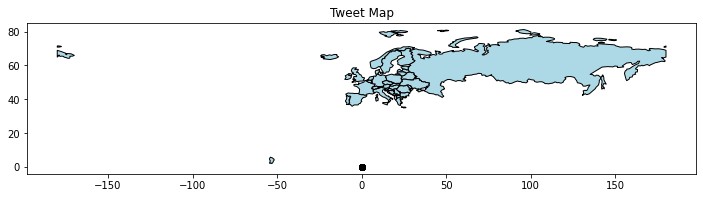

In [7]:
#Now plot the coordinates on a map, not always applicable as does not always give coordinates
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Latitude, df.Longitude))
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
axis = world_data[world_data.continent == 'Europe'].plot(color = 'lightblue', edgecolor = 'black')
df_geo.plot(ax=axis, color = 'black')
plt.title('Tweet Map')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12,12)
fig.savefig('matplot.png', dpi = 200)
plt.show()

In [8]:
#Clean the tweets to remove unwanted characters and data
def cleanTweet (tweet):
  tweet = re.sub('#bitcoin', 'bitcoin', tweet) #Remove hashtag from bitcoin or Bitcoin
  tweet = re.sub('#Bitcoin', 'Bitcoin', tweet)
  tweet = re.sub('#[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('@[A-Za-z0-9]+', '', tweet) #Remove any strings with an @
  tweet = re.sub('$[A-Za-z0-9]+', '', tweet) #Remove any strings with a $
  tweet = re.sub('[!,*)@#%(&$_?.^]', '', tweet) #Remove any strings with a []
  tweet = re.sub('\\n', '', tweet) #removing the '\n' string
  tweet = re.sub('https', '', tweet) #remove any hyperlinks
  tweet = re.sub('http', '', tweet) #remove any hyperlinks
  return tweet

#Call the function and clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTweet)
df.head()

,Tweets,Longitude,Latitude,geometry
0,NEW - 8 more cases of confirmed in England br...,0.0,0.0,POINT (0.00000 0.00000)
1,Highest inflation since introduction of the eu...,0.0,0.0,POINT (0.00000 0.00000)
2,This has been approved in but WON'T apply to ...,0.0,0.0,POINT (0.00000 0.00000)
3,THIS ://tco/4vrJyu3Ddu,0.0,0.0,POINT (0.00000 0.00000)
4,: Office Christmas party bookings are still la...,0.0,0.0,POINT (0.00000 0.00000)


In [9]:
#Now get the most common words used in tweets about the search term of interest
clean_tweet_list = [cleanTweet(tweet) for tweet in all_tweets]
words_in_tweet = [tweet.lower().split() for tweet in clean_tweet_list]
clean_tweet_list = list(itertools.chain(*words_in_tweet))
count = collections.Counter(clean_tweet_list) #create the counter
count.most_common(15) #count the 15 most common words from the tweets
clean_tweet_list = pd.DataFrame(count.most_common(15),columns=['words', 'count']) #create the DF and look at it
clean_tweet_list.head()

,words,count
0,the,542
1,to,392
2,of,275
3,a,244
4,in,240


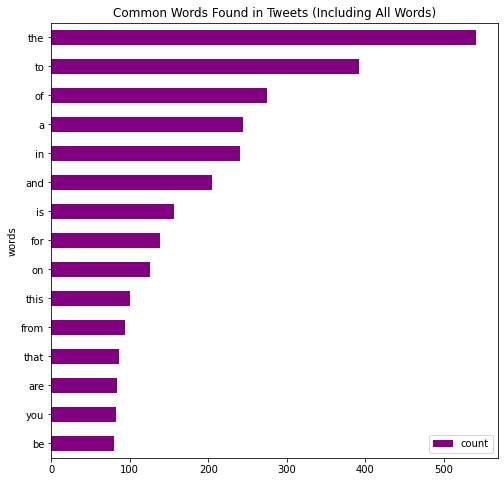

In [10]:
# Plot bar graph of the most common words to visualise it this wau
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweet_list.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Common Words Found in Tweets (Including All Words)")
plt.show()

In [11]:
# Use of textblob NLTK lib https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524
#create a function to get the subjectivity, values between 0 and 1 where 1 is a high degree of personal opinion and not fact
def getSubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity
#create a function to get the polarity, values bwteen [-1:1] -1 is negative, 1 is a positive sentiment
def getPolarity(tweet):
  return TextBlob(tweet).sentiment.polarity
#Create DFs to hold the results of the above functions and then view the DF
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df.head()

#create a function to get the sentiment text
def getSentiment(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive' 

#create a column to store the text sentiment
df['Sentiment'] = df['Polarity'].apply(getSentiment)

#print positive tweets
j=1
sortedDF = df.sort_values(by=['Polarity'])
for i in range (0, sortedDF.shape[0]):
  if (sortedDF['Sentiment'][i]=='Positive'):
    print(str(j) + ')' + sortedDF['Tweets'][i])
    print()
    j = j+1

1)NEW - 8 more cases of  confirmed in England bringing UK total of known cases to 22  19

2): Office Christmas party bookings are still largely going ahead despite concerns over the new Omicron coron… ://tco/HBz0XClwnM

3)8 further  cases identified in England today  That’s 22 in the UK so far ://tco/4tdqJhERDF

4)Live now in Grand Committee work taking place away from the chamber  scrutiny of regulations includ… ://tco/Pw8MQGfVsP

5)    Don't worry the tories are making sure UK taxes goes only to the… ://tco/GaviQcgEoS

6)Following the latest Government announcement we ask anyone coming into our branches to wear a face maskStaff wil… ://tco/vHum6b05FR

7)Take a look at our new research report and my latest blog We explored the national  policy response t… ://tco/1XoV8rvmsS

8)Funding to cover teachers who are absent due to  has been made available once again by  as w… ://tco/gdgAAv1iTV

9)Am concerned this said “Booster” Vaccines based off new variants would mimic IPhone releases We’r

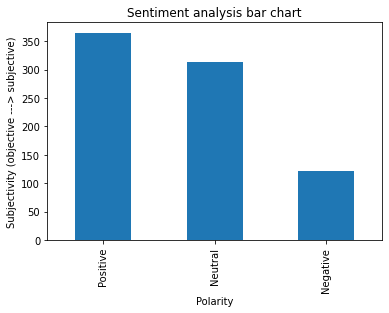

In [12]:
#Visualise the sentiment analysis, how many of each kind of tweet was there
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment analysis bar chart')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity (objective ---> subjective)')
plt.show()

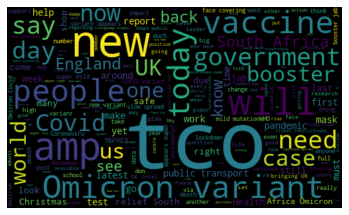

In [13]:
#Plot a word cloud
allWords = ''.join([twts for twts in df['Tweets']])
wordcloud = WordCloud(width = 500, height = 300, random_state= 21, max_font_size=119).generate(allWords)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()